What data to use for the classifier: Or in particular: Can we use the data used for lda training? It is unsupervised, so yes. We did look at the genres only for evaluation purposes, not as means of model selection. Only using a Kfold now would be a bit messy. Should have done model selection on every subset then. So will use cross validation for hyper parameter tuning again. SGD with modified huber loss worked well in https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28. Therefore use that. Here there is no big class imbalance, so do not need class_weight=balanced. Test different levels of regularization alpha

In [1]:
import gensim
import gensim.corpora as corpora
import os
import pandas as pd
import numpy as np
seed = 61

In [2]:
num_topics = 100
model_train = gensim.models.LdaModel.load('./results/lda_'+str(num_topics)+'.model')
df_train = pd.read_pickle(os.path.join("results", "df_train"))
df_test = pd.read_pickle(os.path.join("results", "df_test"))
corpus_train = corpora.MmCorpus(os.path.join("results", "corpus_train"))
corpus_test = corpora.MmCorpus(os.path.join("results", "corpus_test"))

In [3]:
#FIRST WITHOUT REMOVING VERBS
#GET FEATURE VECTORS
train_vecs = []
for i in range(len(df_train)):
    top_topics = model_train.get_document_topics(corpus_train[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    train_vecs.append(topic_vec)

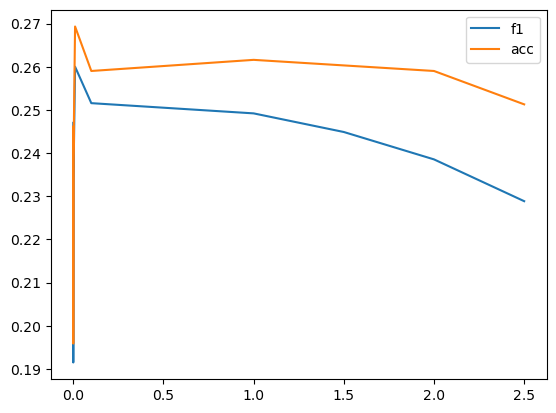

In [4]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#convert genre into categorical
categories = {'pop': 0, 'r-b':1, 'country':2, 'rock':3, 'rap':4}
df_train['genre_categorical'] = df_train.genre.apply(lambda x: categories[x])
df_test['genre_categorical'] = df_test.genre.apply(lambda x: categories[x])

X = np.array(train_vecs)
y = np.array(df_train.genre_categorical)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=seed)

#Scale data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)

#Hyperparameter selection
alphas = [0.00001,0.0001,0.001,0.01,0.1,1.0,1.5,2.0,2.5]
f1s = []
accs = []
for alpha in alphas:
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=alpha,
        loss='modified_huber',
        random_state=seed
    ).fit(X_train_scale, y_train)

    y_pred = sgd_huber.predict(X_val_scale)
    f1s.append(f1_score(y_val, y_pred, average='macro'))
    accs.append(accuracy_score(y_val, y_pred))

#plot
plt.plot(alphas, f1s, label="f1")
plt.plot(alphas, accs, label="acc")
plt.legend()
plt.show()

Results: Best for alpha=0.01 with around 0.26 f1 score

Maybe better for less topics?

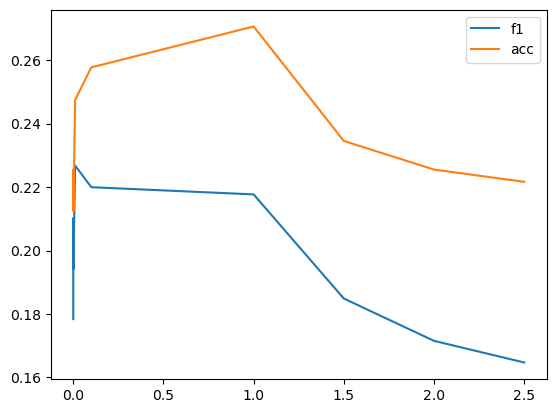

In [5]:
#TEST WHETHER BETTER RESULTS FOR LESS TOPICS
train_vecs_short = []
for i in range(len(df_train)):
    top_topics = model_train.get_document_topics(corpus_train[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(50)]
    train_vecs_short.append(topic_vec)

X_short = np.array(train_vecs_short)
X_short_train, X_short_val, y_short_train, y_short_val = train_test_split(X_short,y, test_size=0.3, random_state=seed)

#Scale data
scaler = StandardScaler()
X_short_train_scale = scaler.fit_transform(X_short_train)
X_short_val_scale = scaler.transform(X_short_val)

#Hyperparameter selection
alphas = [0.00001,0.0001,0.001,0.01,0.1,1.0,1.5,2.0,2.5]
f1s = []
accs = []
for alpha in alphas:
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=alpha,
        loss='modified_huber',
        random_state=seed
    ).fit(X_short_train_scale, y_short_train)

    y_short_pred = sgd_huber.predict(X_short_val_scale)
    f1s.append(f1_score(y_short_val, y_short_pred, average='macro'))
    accs.append(accuracy_score(y_short_val, y_short_pred))

#plot
plt.plot(alphas, f1s, label="f1")
plt.plot(alphas, accs, label="acc")
plt.legend()
plt.show()

Even worse results. Best f1 score around 0.22 (Accuracy not very good metric). take all 100 topics.

In [6]:
#try logistic regression as maybe better model
lr = linear_model.LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True,
        random_state=seed
    ).fit(X_train_scale, y_train)
y_pred = lr.predict(X_val_scale)
print(f1_score(y_val, y_pred, average='macro'))
print(accuracy_score(y_val, y_pred))

0.27421661774402145
0.27190721649484534


best result here: Take logistic regression

In [7]:
#GET PERFORMANCE ON TEST SET
#Get feature vectors 
test_vecs = []
for i in range(len(df_test)):
    top_topics = model_train.get_document_topics(corpus_test[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    test_vecs.append(topic_vec)
X_test = np.array(test_vecs)
y_test = np.array(df_test.genre_categorical)

#Scale data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X)#Remark: Now on full df_train
X_test_scale = scaler.transform(X_test)
y_train = y
#Train on full data and look at test error
lr_full = linear_model.LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True,
        random_state=seed
    ).fit(X_train_scale, y_train)

y_pred = lr_full.predict(X_test_scale)
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_test, y_pred))

0.37245447020330974
0.3655234657039711


Aparrently model was overfitting (but why better to take more features), now with a little more data get better results: 0.37 f1-score

Thats not particularly good, but much better than random guess (1/5=0.2). But it shows that it is hard to separate topics between genres. Are there particular genres that are hard to classify?

In [8]:
#LOOK AT ACCURACY PER GENRE
for i in range(5):
    print("Genre: ", list(categories.keys())[list(categories.values()).index(i)])
    ind_genre = y_test == i
    y_genre_test = y_test[ind_genre]
    y_genre_pred = y_pred[ind_genre]
    print("percentage of data: ", len(y_genre_test)/len(y_test))
    print("acc score: ", accuracy_score(y_genre_test, y_genre_pred))
    

Genre:  pop
percentage of data:  0.18231046931407943
acc score:  0.2524752475247525
Genre:  r-b
percentage of data:  0.21660649819494585
acc score:  0.35
Genre:  country
percentage of data:  0.2157039711191336
acc score:  0.3514644351464435
Genre:  rock
percentage of data:  0.20577617328519857
acc score:  0.2324561403508772
Genre:  rap
percentage of data:  0.1796028880866426
acc score:  0.6683417085427136


So some genres are easier to classify, especially rap. On the other hand, rock and pop seem to be the hardest. This is not a problem of class imbalance.

Need an understanding of how hard it generally is to differentiate between genres from lyrics and whether these results are due to the topics.
But first: How is it when removing verbs as stop words

In [9]:
#NOW: WITH VERBS REMOVED
num_topics = 100
name = str(num_topics)+"_extended"
model_train_extended = gensim.models.LdaModel.load('./results/lda_'+name+'.model')
corpus_train_extended = corpora.MmCorpus(os.path.join("results", "corpus_train_extended"))
corpus_test_extended = corpora.MmCorpus(os.path.join("results", "corpus_test_extended"))

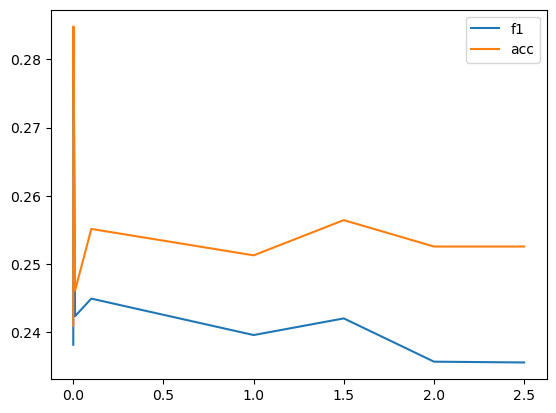

0.25580644518944495
0.2551546391752577


In [10]:
#GET DATA AND TRAIN SEVERAL MODELS TO CHOOSE FROM
train_vecs_extended = []
for i in range(len(df_train)):
    top_topics = model_train_extended.get_document_topics(corpus_train_extended[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    train_vecs_extended.append(topic_vec)

#convert genre into categorical
categories = {'pop': 0, 'r-b':1, 'country':2, 'rock':3, 'rap':4}
df_train['genre_categorical'] = df_train.genre.apply(lambda x: categories[x])
df_test['genre_categorical'] = df_test.genre.apply(lambda x: categories[x])
    
X_extended = np.array(train_vecs_extended)
y = np.array(df_train.genre_categorical)

X_train_extended, X_val_extended, y_train, y_val = train_test_split(X_extended,y, test_size=0.3, random_state=seed)

#Scale data
scaler = StandardScaler()
X_train_extended_scale = scaler.fit_transform(X_train_extended)
X_val_extended_scale = scaler.transform(X_val_extended)

#Hyperparameter selection
alphas = [0.00001,0.0001,0.001,0.01,0.1,1.0,1.5,2.0,2.5]
f1s = []
accs = []
for alpha in alphas:
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=alpha,
        loss='modified_huber',
        random_state=seed
    ).fit(X_train_extended_scale, y_train)

    y_pred_extended = sgd_huber.predict(X_val_extended_scale)
    f1s.append(f1_score(y_val, y_pred_extended, average='macro'))
    accs.append(accuracy_score(y_val, y_pred_extended))

#plot
plt.plot(alphas, f1s, label="f1")
plt.plot(alphas, accs, label="acc")
plt.legend()
plt.show()

#try logistic regression as maybe better model
lr = linear_model.LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True,
        random_state=seed
    ).fit(X_train_extended_scale, y_train)
y_pred = lr.predict(X_val_extended_scale)
print(f1_score(y_val, y_pred, average='macro'))
print(accuracy_score(y_val, y_pred))

Results: Again logistic Regression brings best results with an f1 score of ca. 0.26

In [12]:
#GET TEST PERFORMANCE
#get features
test_vecs_extended = []
for i in range(len(df_test)):
    top_topics = model_train_extended.get_document_topics(corpus_test_extended[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(100)]
    test_vecs_extended.append(topic_vec)
X_test_extended = np.array(test_vecs_extended)
y_test = np.array(df_test.genre_categorical)

#Scale data
scaler = StandardScaler()
X_train_extended_scale = scaler.fit_transform(X_extended)
X_test_extended_scale = scaler.transform(X_test_extended)
y_train = y
#Train on full data and look at test error
lr_full = linear_model.LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True,
        random_state=seed
    ).fit(X_train_extended_scale, y_train)

y_pred = lr_full.predict(X_test_extended_scale)
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_test, y_pred))

0.3547998202528236
0.3483754512635379


In [13]:
#LOOK AT ACCURACY PER GENRE
for i in range(5):
    print("Genre: ", list(categories.keys())[list(categories.values()).index(i)])
    ind_genre = y_test == i
    y_genre_test = y_test[ind_genre]
    y_genre_pred = y_pred[ind_genre]
    print("percentage of data: ", len(y_genre_test)/len(y_test))
    print("acc score: ", accuracy_score(y_genre_test, y_genre_pred))

Genre:  pop
percentage of data:  0.18231046931407943
acc score:  0.25742574257425743
Genre:  r-b
percentage of data:  0.21660649819494585
acc score:  0.2916666666666667
Genre:  country
percentage of data:  0.2157039711191336
acc score:  0.38493723849372385
Genre:  rock
percentage of data:  0.20577617328519857
acc score:  0.21052631578947367
Genre:  rap
percentage of data:  0.1796028880866426
acc score:  0.6231155778894473


Results:
- Similar performances when removing verbs
- Only really increases accuracy on r-b in comparison to not removing verbs
- rock and pop still only as good as random guess

In [14]:
#COMPUTING BASELINE: Preprocessing
#Use lyrics_processed: But there stopwords not yet removed, bc only did that for corpus
#Since have not too much data, keep verbs
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'la','oh','also', 'yeah', 'ooh','uh','chorus','verse','outro','bridge'])
def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    return text
df_train['lyric_processed'] = df_train['lyric_processed'].apply(remove_stopwords)
df_test['lyric_processed'] = df_test['lyric_processed'].apply(remove_stopwords)

X = df_train.lyric_processed
y = df_train.genre_categorical
X_test = df_test.lyric_processed
y_test = df_test.genre_categorical

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=seed)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#TRY SEVERAL MODELS: similar to https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
#1.) Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_val)

print('f1-score %s' % f1_score(y_pred, y_val, average="macro"))
print(classification_report(y_val, y_pred,target_names=list(categories.keys())))


f1-score 0.3711959003893885
              precision    recall  f1-score   support

         pop       0.00      0.00      0.00       137
         r-b       0.42      0.69      0.52       173
     country       0.36      0.80      0.50       165
        rock       0.45      0.08      0.14       174
         rap       0.81      0.61      0.70       127

    accuracy                           0.44       776
   macro avg       0.41      0.44      0.37       776
weighted avg       0.40      0.44      0.37       776



In [16]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_val)

print('f1-score %s' % f1_score(y_pred, y_val, average="macro"))
print(classification_report(y_val, y_pred,target_names=list(categories.keys())))

f1-score 0.46465747238466093
              precision    recall  f1-score   support

         pop       0.31      0.15      0.20       137
         r-b       0.49      0.53      0.51       173
     country       0.45      0.65      0.53       165
        rock       0.40      0.30      0.35       174
         rap       0.68      0.81      0.74       127

    accuracy                           0.48       776
   macro avg       0.47      0.49      0.46       776
weighted avg       0.46      0.48      0.46       776



In [17]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', linear_model.LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_val)

print('f1-score %s' % f1_score(y_pred, y_val, average="macro"))
print(classification_report(y_val, y_pred,target_names=list(categories.keys())))

f1-score 0.47341565869304086
              precision    recall  f1-score   support

         pop       0.29      0.23      0.25       137
         r-b       0.47      0.51      0.49       173
     country       0.54      0.59      0.56       165
        rock       0.41      0.29      0.34       174
         rap       0.62      0.87      0.73       127

    accuracy                           0.49       776
   macro avg       0.47      0.50      0.47       776
weighted avg       0.46      0.49      0.47       776



Results: logistic regression gets best result with so far 0.47 f1 --> take it to compute test performance

In [18]:
logreg.fit(X,y)
y_pred = logreg.predict(X_test)
print('f1-score %s' % f1_score(y_pred, y_test, average="macro"))
print(classification_report(y_test, y_pred,target_names=list(categories.keys())))

f1-score 0.4562994368754324
              precision    recall  f1-score   support

         pop       0.25      0.23      0.24       202
         r-b       0.46      0.44      0.45       240
     country       0.50      0.58      0.54       239
        rock       0.37      0.30      0.33       228
         rap       0.66      0.79      0.72       199

    accuracy                           0.47      1108
   macro avg       0.45      0.47      0.46      1108
weighted avg       0.45      0.47      0.46      1108



Results: Get 0.46 f1 score for classification. Is better than using topic models (0.39), but not too much better.

